In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [20]:
# Initializing hyperparams 
latent_dim = 100 
batch_size = 64 
epochs = 50 
learning_rate = 2e-4

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [22]:
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize([0.5], [0.5])
])

train_dataset = datasets.MNIST(
    root = './datasets' , train = True, download = True, transform = transform
)
train_loader = DataLoader(train_dataset, shuffle = True, batch_size = batch_size)

In [23]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # Input: B x latent_dim x 1 x 1
        # Layer 1: -> B x 256 x 4 x 4
        self.network = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels = latent_dim, 
                out_channels = 256, 
                kernel_size = 4,
                stride = 1, 
                padding = 0, 
                bias = False 
            ),                    
            nn.BatchNorm2d(num_features = 256),
            nn.ReLU(inplace = True), 
            
            # Layer 2: -> B x 128 x 8 x 8
            nn.ConvTranspose2d(
                in_channels = 256, 
                out_channels = 128, 
                kernel_size = 4,
                stride = 2, 
                padding = 1, 
                bias = False 
            ),                     # input to G : (latent_dim x 1 x 1)
            nn.BatchNorm2d(num_features = 128),
            nn.ReLU(inplace = True), 
            
            # Layer 3: -> B x 64 x 16 x 16
            nn.ConvTranspose2d(
                in_channels = 128, 
                out_channels = 64, 
                kernel_size = 4,
                stride = 2, 
                padding = 1, 
                bias = False 
            ),                     # input to G : (latent_dim x 1 x 1)
            nn.BatchNorm2d(num_features = 64),
            nn.ReLU(inplace = True), 
            
            # Layer 4: -> B x 1 x 28 x  
            nn.ConvTranspose2d(
                in_channels = 64, 
                out_channels = 1, 
                kernel_size = 4,
                stride = 2, 
                padding = 3, 
                bias = False  
            ), 
            nn.Tanh()            # output : [-1, 1]
        )
    
    def forward(self, x):
        return self.network(x)

In [24]:
import torch
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # Input: B x 1 x 28 x 28
        self.network = nn.Sequential(
            # Layer 1: B x 1 x 28 x 28 -> B x 64 x 14 x 14
            # H_out = floor((H_in - K + 2P) / S + 1)
            # H_out = floor((28 - 4 + 2*1) / 2 + 1) = floor(26/2 + 1) = 14
            nn.Conv2d(
                in_channels=1, 
                out_channels=64, 
                kernel_size=4,
                stride=2, 
                padding=1, 
                bias=False
            ), 
            nn.LeakyReLU(0.2, inplace=True),
            
            # Layer 2: B x 64 x 14 x 14 -> B x 128 x 7 x 7
            # H_out = floor((14 - 4 + 2*1) / 2 + 1) = floor(12/2 + 1) = 7
            nn.Conv2d(
                in_channels=64, 
                out_channels=128, 
                kernel_size=4,
                stride=2, 
                padding=1, 
                bias=False
            ), 
            nn.BatchNorm2d(num_features=128),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Layer 3: B x 128 x 7 x 7 -> B x 256 x 3 x 3
            # H_out = floor((7 - 4 + 2*1) / 2 + 1) = floor(5/2 + 1) = floor(3.5) = 3
            nn.Conv2d(
                in_channels=128, 
                out_channels=256, 
                kernel_size=4,
                stride=2, 
                padding=1, 
                bias=False
            ), 
            nn.BatchNorm2d(num_features=256),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Layer 4 (Output): B x 256 x 3 x 3 -> B x 1 x 1 x 1
            # H_out = floor((3 - 3 + 2*0) / 1 + 1) = 1
            nn.Conv2d(
                in_channels=256, 
                out_channels=1, 
                kernel_size=3, # Kernel size matches the input spatial dimension (3x3)
                stride=1, 
                padding=0, 
                bias=False
            ), 
            nn.Sigmoid() # Output is B x 1 x 1 x 1
        )
    
    def forward(self, x):
        # You can add print statements here for debugging:
        # print(f"Discriminator input shape: {x.shape}")
        output_before_view = self.network(x)
        # print(f"Discriminator network output shape (before view): {output_before_view.shape}")
        output_after_view = output_before_view.view(-1)
        # print(f"Discriminator final output shape (after view): {output_after_view.shape}")
        return output_after_view

In [25]:
def show_images(images):
    # convert from [-1, 1] -> [0, 1]
    images  = (images + 1) / 2 
    fig, ax = plt.subplots(figsize=(8,8))
    ax.imshow(
        make_grid(
            images.detach().cpu(), 
            padding = 2, 
            normalize = False 
        ).permute(1, 2, 0)
    )
    plt.axis('off')
    plt.show()

In [26]:
G = Generator().to(device)
D = Discriminator().to(device)

optimizer_G = optim.Adam(params = G.parameters(), lr = learning_rate, betas = (0.5, 0.999))
optimizer_D = optim.Adam(params = D.parameters(), lr = learning_rate, betas = (0.5, 0.999))

criterion = nn.BCELoss()

### GAN Training Loop

Start training...
Epoch [1/50], D Loss: 0.2950, G Loss: 1.7169


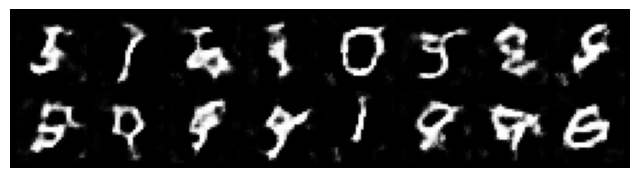

Epoch [2/50], D Loss: 0.2723, G Loss: 1.1995
Epoch [3/50], D Loss: 0.1085, G Loss: 3.0172
Epoch [4/50], D Loss: 0.2016, G Loss: 3.7236
Epoch [5/50], D Loss: 0.1820, G Loss: 1.9727
Epoch [6/50], D Loss: 0.1972, G Loss: 3.1150


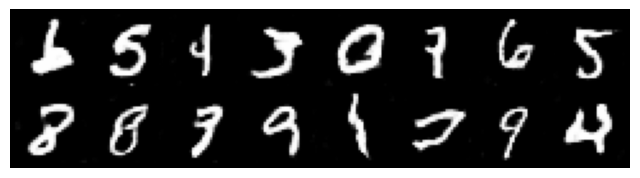

Epoch [7/50], D Loss: 0.2439, G Loss: 3.8733
Epoch [8/50], D Loss: 0.2775, G Loss: 1.5880
Epoch [9/50], D Loss: 0.2707, G Loss: 3.5590
Epoch [10/50], D Loss: 0.3144, G Loss: 1.7571
Epoch [11/50], D Loss: 0.2006, G Loss: 2.0201


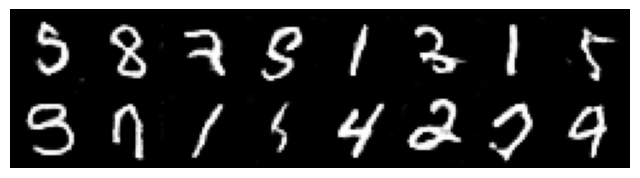

Epoch [12/50], D Loss: 0.1310, G Loss: 4.2802
Epoch [13/50], D Loss: 0.1499, G Loss: 4.2868
Epoch [14/50], D Loss: 0.1010, G Loss: 3.6085
Epoch [15/50], D Loss: 0.1273, G Loss: 2.3622
Epoch [16/50], D Loss: 0.1025, G Loss: 3.9499


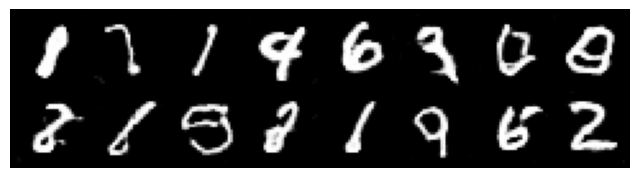

Epoch [17/50], D Loss: 0.1045, G Loss: 4.2594
Epoch [18/50], D Loss: 0.2217, G Loss: 2.7937


KeyboardInterrupt: 

In [27]:
print('Start training...')
for epoch in range(epochs):
    for i, (real_images, _) in enumerate(train_loader):
        # print(f"Shape of real_images: {real_images.shape}") # Should be [64, 1, 28, 28]
        current_batch_size = real_images.size(0) 
        
        real_labels = torch.ones(current_batch_size, device = device)
        fake_labels = torch.zeros(current_batch_size, device = device)
        
        real_images = real_images.to(device)
        
        # DISCRIMINATOR TRAINING 
        optimizer_D.zero_grad()
        
        outputs_real = D(real_images)
        # print(f"Shape of outputs_real from D: {outputs_real.shape}") # Should be [64]
        loss_real = criterion(outputs_real, real_labels)
        
        z = torch.randn(current_batch_size, latent_dim, 1, 1, device = device)
        fake_images = G(z) 
        outputs_fake = D(fake_images.detach())
        loss_fake = criterion(outputs_fake, fake_labels)
        
        loss_D = (loss_real + loss_fake) / 2 
        loss_D.backward()
        optimizer_D.step()
        
        # GENERATOR TRAINING 
        optimizer_G.zero_grad() 
        
        outputs = D(fake_images)
        loss_G = criterion(outputs, real_labels)
        loss_G.backward()
        optimizer_G.step()
    
    print(f"Epoch [{epoch+1}/{epochs}], D Loss: {loss_D.item():.4f}, G Loss: {loss_G.item():.4f}")
    if epoch % 5 == 0 or epoch == 0:
        with torch.no_grad():
            test_z = torch.randn(16, latent_dim, 1, 1, device = device)
            fakes = G(test_z)
            show_images(fakes)

print('Training complete!')
        